In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #     rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=rates_equal)) # 0-1
    #     targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/arasdar/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:1.3796 dloss:2.0600 glossQ:1.0031 dlossQ:0.8601 exploreP:0.9985
Episode:1 meanR:16.0000 R:17.0000 rate:0.0340 gloss:1.3770 dloss:2.0488 glossQ:1.0042 dlossQ:0.8682 exploreP:0.9968
Episode:2 meanR:15.3333 R:14.0000 rate:0.0280 gloss:1.3758 dloss:2.0381 glossQ:1.0061 dlossQ:0.8926 exploreP:0.9955
Episode:3 meanR:15.5000 R:16.0000 rate:0.0320 gloss:1.3767 dloss:2.0438 glossQ:1.0051 dlossQ:0.8796 exploreP:0.9939
Episode:4 meanR:16.6000 R:21.0000 rate:0.0420 gloss:1.3773 dloss:2.0367 glossQ:1.0021 dlossQ:0.8863 exploreP:0.9918
Episode:5 meanR:17.0000 R:19.0000 rate:0.0380 gloss:1.3699 dloss:2.0171 glossQ:1.0072 dlossQ:0.8879 exploreP:0.9900
Episode:6 meanR:16.4286 R:13.0000 rate:0.0260 gloss:1.3704 dloss:2.0041 glossQ:1.0092 dlossQ:0.9066 exploreP:0.9887
Episode:7 meanR:16.6250 R:18.0000 rate:0.0360 gloss:1.3689 dloss:2.0033 glossQ:1.0104 dlossQ:0.9128 exploreP:0.9869
Episode:8 meanR:16.4444 R:15.0000 rate:0.0300 gloss:1.3679 dloss:1.9982 

Episode:71 meanR:21.8889 R:16.0000 rate:0.0320 gloss:1.2285 dloss:1.5124 glossQ:1.1581 dlossQ:0.9786 exploreP:0.8556
Episode:72 meanR:22.0411 R:33.0000 rate:0.0660 gloss:1.2696 dloss:nan glossQ:1.3944 dlossQ:1.1682 exploreP:0.8529
Episode:73 meanR:22.0811 R:25.0000 rate:0.0500 gloss:1.2418 dloss:1.5478 glossQ:1.1237 dlossQ:0.9059 exploreP:0.8508
Episode:74 meanR:22.7200 R:70.0000 rate:0.1400 gloss:1.2210 dloss:1.4994 glossQ:1.1366 dlossQ:0.8741 exploreP:0.8449
Episode:75 meanR:22.5526 R:10.0000 rate:0.0200 gloss:1.2117 dloss:1.4898 glossQ:1.1372 dlossQ:0.8606 exploreP:0.8441
Episode:76 meanR:22.5065 R:19.0000 rate:0.0380 gloss:1.2071 dloss:1.4448 glossQ:1.1588 dlossQ:0.8295 exploreP:0.8425
Episode:77 meanR:22.3974 R:14.0000 rate:0.0280 gloss:1.2262 dloss:1.4925 glossQ:1.1993 dlossQ:0.9036 exploreP:0.8413
Episode:78 meanR:22.7089 R:47.0000 rate:0.0940 gloss:1.2036 dloss:1.4470 glossQ:1.1652 dlossQ:0.7897 exploreP:0.8374
Episode:79 meanR:22.5625 R:11.0000 rate:0.0220 gloss:1.1878 dloss:1

Episode:141 meanR:20.9000 R:22.0000 rate:0.0440 gloss:1.0899 dloss:1.1934 glossQ:1.1865 dlossQ:0.9253 exploreP:0.7397
Episode:142 meanR:20.8800 R:27.0000 rate:0.0540 gloss:1.0710 dloss:1.1692 glossQ:1.1940 dlossQ:0.9115 exploreP:0.7377
Episode:143 meanR:20.3400 R:12.0000 rate:0.0240 gloss:1.0480 dloss:1.1381 glossQ:1.2440 dlossQ:0.9031 exploreP:0.7368
Episode:144 meanR:20.2100 R:10.0000 rate:0.0200 gloss:1.0713 dloss:1.1735 glossQ:1.1937 dlossQ:0.9189 exploreP:0.7361
Episode:145 meanR:20.1400 R:12.0000 rate:0.0240 gloss:1.0648 dloss:1.1554 glossQ:1.1867 dlossQ:0.8738 exploreP:0.7352
Episode:146 meanR:20.0400 R:16.0000 rate:0.0320 gloss:1.0744 dloss:1.1655 glossQ:1.1866 dlossQ:0.8586 exploreP:0.7341
Episode:147 meanR:20.0200 R:15.0000 rate:0.0300 gloss:1.0755 dloss:1.1669 glossQ:1.2073 dlossQ:0.8822 exploreP:0.7330
Episode:148 meanR:20.0400 R:15.0000 rate:0.0300 gloss:1.0657 dloss:1.1637 glossQ:1.2019 dlossQ:0.8786 exploreP:0.7319
Episode:149 meanR:19.9300 R:9.0000 rate:0.0180 gloss:1.0

Episode:211 meanR:20.8700 R:11.0000 rate:0.0220 gloss:1.1354 dloss:1.2781 glossQ:1.1456 dlossQ:0.7358 exploreP:0.6414
Episode:212 meanR:20.4900 R:12.0000 rate:0.0240 gloss:1.1293 dloss:1.2604 glossQ:1.1368 dlossQ:0.6841 exploreP:0.6407
Episode:213 meanR:20.5400 R:16.0000 rate:0.0320 gloss:1.1084 dloss:1.2342 glossQ:1.1609 dlossQ:0.6938 exploreP:0.6397
Episode:214 meanR:20.4200 R:10.0000 rate:0.0200 gloss:1.1091 dloss:1.2454 glossQ:1.1481 dlossQ:0.7024 exploreP:0.6390
Episode:215 meanR:20.4100 R:11.0000 rate:0.0220 gloss:1.1266 dloss:1.2537 glossQ:1.1489 dlossQ:0.6781 exploreP:0.6384
Episode:216 meanR:20.4300 R:15.0000 rate:0.0300 gloss:1.1209 dloss:1.2407 glossQ:1.1459 dlossQ:0.6549 exploreP:0.6374
Episode:217 meanR:20.4000 R:14.0000 rate:0.0280 gloss:1.0991 dloss:1.2179 glossQ:1.1701 dlossQ:0.6656 exploreP:0.6365
Episode:218 meanR:20.3900 R:23.0000 rate:0.0460 gloss:1.1017 dloss:1.2129 glossQ:1.1638 dlossQ:0.6335 exploreP:0.6351
Episode:219 meanR:20.2800 R:12.0000 rate:0.0240 gloss:1.

Episode:281 meanR:16.7300 R:10.0000 rate:0.0200 gloss:1.1041 dloss:1.2431 glossQ:1.1422 dlossQ:1.1081 exploreP:0.5804
Episode:282 meanR:16.6400 R:19.0000 rate:0.0380 gloss:1.0850 dloss:1.2168 glossQ:1.1536 dlossQ:1.0530 exploreP:0.5793
Episode:283 meanR:16.4300 R:14.0000 rate:0.0280 gloss:1.0962 dloss:1.2230 glossQ:1.1576 dlossQ:1.0157 exploreP:0.5785
Episode:284 meanR:16.1900 R:19.0000 rate:0.0380 gloss:1.0710 dloss:1.1919 glossQ:1.1774 dlossQ:1.0007 exploreP:0.5774
Episode:285 meanR:16.1700 R:20.0000 rate:0.0400 gloss:1.0672 dloss:1.1776 glossQ:1.1710 dlossQ:0.9384 exploreP:0.5763
Episode:286 meanR:15.9800 R:12.0000 rate:0.0240 gloss:1.0527 dloss:1.1622 glossQ:1.2131 dlossQ:0.9584 exploreP:0.5756
Episode:287 meanR:15.9300 R:21.0000 rate:0.0420 gloss:1.0455 dloss:1.1464 glossQ:1.1759 dlossQ:0.8837 exploreP:0.5744
Episode:288 meanR:15.7100 R:14.0000 rate:0.0280 gloss:1.0472 dloss:1.1281 glossQ:1.1859 dlossQ:0.7916 exploreP:0.5736
Episode:289 meanR:15.5900 R:14.0000 rate:0.0280 gloss:1.

Episode:351 meanR:15.6900 R:14.0000 rate:0.0280 gloss:1.1312 dloss:1.3066 glossQ:1.1333 dlossQ:1.1130 exploreP:0.5180
Episode:352 meanR:15.7400 R:15.0000 rate:0.0300 gloss:1.1394 dloss:1.3197 glossQ:1.1114 dlossQ:1.1089 exploreP:0.5172
Episode:353 meanR:15.7900 R:15.0000 rate:0.0300 gloss:1.1665 dloss:1.3464 glossQ:1.1243 dlossQ:1.1116 exploreP:0.5164
Episode:354 meanR:15.8700 R:19.0000 rate:0.0380 gloss:1.1633 dloss:1.3424 glossQ:1.1272 dlossQ:1.0850 exploreP:0.5155
Episode:355 meanR:15.9200 R:19.0000 rate:0.0380 gloss:1.1488 dloss:1.3273 glossQ:1.1399 dlossQ:1.1123 exploreP:0.5145
Episode:356 meanR:15.9500 R:15.0000 rate:0.0300 gloss:1.1534 dloss:1.3306 glossQ:1.1283 dlossQ:1.0535 exploreP:0.5138
Episode:357 meanR:15.9500 R:11.0000 rate:0.0220 gloss:1.1415 dloss:1.3175 glossQ:1.1324 dlossQ:1.0523 exploreP:0.5132
Episode:358 meanR:15.9600 R:14.0000 rate:0.0280 gloss:1.1436 dloss:1.3180 glossQ:1.1409 dlossQ:1.0306 exploreP:0.5125
Episode:359 meanR:15.9600 R:11.0000 rate:0.0220 gloss:1.

Episode:421 meanR:14.8600 R:11.0000 rate:0.0220 gloss:1.0718 dloss:1.1624 glossQ:1.2723 dlossQ:0.8118 exploreP:0.4731
Episode:422 meanR:14.8500 R:10.0000 rate:0.0200 gloss:1.0638 dloss:1.1416 glossQ:1.1710 dlossQ:0.6446 exploreP:0.4726
Episode:423 meanR:14.8000 R:24.0000 rate:0.0480 gloss:1.0786 dloss:1.1629 glossQ:1.1673 dlossQ:0.6976 exploreP:0.4715
Episode:424 meanR:14.8400 R:19.0000 rate:0.0380 gloss:1.0552 dloss:1.1683 glossQ:1.1992 dlossQ:0.8806 exploreP:0.4706
Episode:425 meanR:14.8400 R:13.0000 rate:0.0260 gloss:1.0683 dloss:1.1800 glossQ:1.1609 dlossQ:0.8466 exploreP:0.4700
Episode:426 meanR:14.8000 R:9.0000 rate:0.0180 gloss:1.0676 dloss:1.1627 glossQ:1.1566 dlossQ:0.7166 exploreP:0.4696
Episode:427 meanR:14.9400 R:24.0000 rate:0.0480 gloss:1.0681 dloss:1.1903 glossQ:1.1708 dlossQ:0.9215 exploreP:0.4685
Episode:428 meanR:14.8900 R:13.0000 rate:0.0260 gloss:1.0630 dloss:1.1763 glossQ:1.1750 dlossQ:0.8791 exploreP:0.4679
Episode:429 meanR:14.8600 R:11.0000 rate:0.0220 gloss:1.0

Episode:491 meanR:12.9200 R:14.0000 rate:0.0280 gloss:1.0560 dloss:1.1511 glossQ:1.1930 dlossQ:0.8951 exploreP:0.4332
Episode:492 meanR:12.9600 R:13.0000 rate:0.0260 gloss:1.0733 dloss:1.1716 glossQ:1.3678 dlossQ:1.1169 exploreP:0.4326
Episode:493 meanR:12.9600 R:11.0000 rate:0.0220 gloss:1.0403 dloss:1.1350 glossQ:1.1688 dlossQ:0.8813 exploreP:0.4322
Episode:494 meanR:12.9800 R:13.0000 rate:0.0260 gloss:1.0272 dloss:1.1226 glossQ:1.1856 dlossQ:0.8948 exploreP:0.4316
Episode:495 meanR:12.9800 R:12.0000 rate:0.0240 gloss:1.0003 dloss:1.0823 glossQ:1.2191 dlossQ:0.8043 exploreP:0.4311
Episode:496 meanR:12.9900 R:11.0000 rate:0.0220 gloss:1.0457 dloss:1.1131 glossQ:1.2476 dlossQ:0.8231 exploreP:0.4307
Episode:497 meanR:12.9000 R:13.0000 rate:0.0260 gloss:1.0340 dloss:1.1169 glossQ:1.2140 dlossQ:0.8388 exploreP:0.4301
Episode:498 meanR:12.9500 R:15.0000 rate:0.0300 gloss:1.0461 dloss:1.1081 glossQ:1.2854 dlossQ:0.7841 exploreP:0.4295
Episode:499 meanR:12.9300 R:10.0000 rate:0.0200 gloss:1.

Episode:561 meanR:12.8600 R:13.0000 rate:0.0260 gloss:1.1230 dloss:1.2896 glossQ:1.1431 dlossQ:1.1538 exploreP:0.3966
Episode:562 meanR:12.8800 R:15.0000 rate:0.0300 gloss:1.1093 dloss:1.2765 glossQ:1.1454 dlossQ:1.1610 exploreP:0.3960
Episode:563 meanR:12.8900 R:11.0000 rate:0.0220 gloss:1.1263 dloss:1.3055 glossQ:1.1306 dlossQ:1.2062 exploreP:0.3956
Episode:564 meanR:12.8300 R:11.0000 rate:0.0220 gloss:1.1133 dloss:1.2711 glossQ:1.1598 dlossQ:1.1230 exploreP:0.3951
Episode:565 meanR:12.8100 R:12.0000 rate:0.0240 gloss:1.1104 dloss:1.2851 glossQ:1.1540 dlossQ:1.2251 exploreP:0.3947
Episode:566 meanR:12.7900 R:14.0000 rate:0.0280 gloss:1.1118 dloss:1.2835 glossQ:1.1540 dlossQ:1.1847 exploreP:0.3941
Episode:567 meanR:12.8100 R:13.0000 rate:0.0260 gloss:1.1711 dloss:nan glossQ:1.3646 dlossQ:1.3598 exploreP:0.3936
Episode:568 meanR:12.7900 R:16.0000 rate:0.0320 gloss:1.1372 dloss:1.3236 glossQ:1.1197 dlossQ:1.2199 exploreP:0.3930
Episode:569 meanR:12.9500 R:30.0000 rate:0.0600 gloss:1.164

Episode:631 meanR:12.3100 R:10.0000 rate:0.0200 gloss:1.0106 dloss:1.0801 glossQ:1.2046 dlossQ:0.5616 exploreP:0.3652
Episode:632 meanR:12.2500 R:15.0000 rate:0.0300 gloss:1.0567 dloss:1.1170 glossQ:1.1773 dlossQ:0.5469 exploreP:0.3647
Episode:633 meanR:12.1700 R:12.0000 rate:0.0240 gloss:1.0729 dloss:1.1255 glossQ:1.1756 dlossQ:0.5130 exploreP:0.3643
Episode:634 meanR:12.1700 R:10.0000 rate:0.0200 gloss:1.0341 dloss:1.0966 glossQ:1.1942 dlossQ:0.5530 exploreP:0.3639
Episode:635 meanR:12.1200 R:8.0000 rate:0.0160 gloss:1.0496 dloss:1.1043 glossQ:1.1680 dlossQ:0.5020 exploreP:0.3636
Episode:636 meanR:12.0800 R:10.0000 rate:0.0200 gloss:0.9808 dloss:1.0399 glossQ:1.1794 dlossQ:0.4543 exploreP:0.3633
Episode:637 meanR:12.0900 R:13.0000 rate:0.0260 gloss:1.0213 dloss:1.0753 glossQ:1.1884 dlossQ:0.4923 exploreP:0.3628
Episode:638 meanR:12.0800 R:11.0000 rate:0.0220 gloss:0.9810 dloss:1.0340 glossQ:1.2322 dlossQ:0.4800 exploreP:0.3624
Episode:639 meanR:12.1400 R:15.0000 rate:0.0300 gloss:1.0

Episode:701 meanR:11.7000 R:11.0000 rate:0.0220 gloss:1.0882 dloss:1.2215 glossQ:1.1749 dlossQ:1.1184 exploreP:0.3372
Episode:702 meanR:11.6600 R:9.0000 rate:0.0180 gloss:1.1092 dloss:1.2694 glossQ:1.1528 dlossQ:1.2542 exploreP:0.3369
Episode:703 meanR:11.6500 R:13.0000 rate:0.0260 gloss:1.1265 dloss:1.3282 glossQ:1.1868 dlossQ:1.5199 exploreP:0.3365
Episode:704 meanR:11.7800 R:21.0000 rate:0.0420 gloss:1.1083 dloss:1.2503 glossQ:1.1838 dlossQ:1.1695 exploreP:0.3358
Episode:705 meanR:11.7700 R:9.0000 rate:0.0180 gloss:1.1013 dloss:1.2822 glossQ:1.1927 dlossQ:1.3984 exploreP:0.3355
Episode:706 meanR:11.7400 R:10.0000 rate:0.0200 gloss:1.0974 dloss:1.2857 glossQ:1.1789 dlossQ:1.4296 exploreP:0.3352
Episode:707 meanR:11.7100 R:10.0000 rate:0.0200 gloss:1.0416 dloss:1.1959 glossQ:1.2785 dlossQ:1.3472 exploreP:0.3349
Episode:708 meanR:11.7100 R:10.0000 rate:0.0200 gloss:1.0951 dloss:1.2802 glossQ:1.1871 dlossQ:1.4087 exploreP:0.3345
Episode:709 meanR:11.6500 R:8.0000 rate:0.0160 gloss:1.122

Episode:771 meanR:11.8700 R:22.0000 rate:0.0440 gloss:1.0888 dloss:1.1868 glossQ:1.1644 dlossQ:0.8531 exploreP:0.3110
Episode:772 meanR:11.8900 R:15.0000 rate:0.0300 gloss:1.0386 dloss:1.1384 glossQ:1.2193 dlossQ:0.8769 exploreP:0.3105
Episode:773 meanR:11.8700 R:9.0000 rate:0.0180 gloss:1.0477 dloss:1.1381 glossQ:1.1911 dlossQ:0.7850 exploreP:0.3102
Episode:774 meanR:11.8600 R:11.0000 rate:0.0220 gloss:1.0221 dloss:1.1182 glossQ:1.2302 dlossQ:0.8765 exploreP:0.3099
Episode:775 meanR:11.8600 R:11.0000 rate:0.0220 gloss:1.0362 dloss:1.1020 glossQ:1.2067 dlossQ:0.6958 exploreP:0.3096
Episode:776 meanR:11.8600 R:10.0000 rate:0.0200 gloss:1.0317 dloss:1.1056 glossQ:1.2077 dlossQ:0.7026 exploreP:0.3093
Episode:777 meanR:11.9000 R:13.0000 rate:0.0260 gloss:1.0485 dloss:1.1293 glossQ:1.1936 dlossQ:0.7657 exploreP:0.3089
Episode:778 meanR:11.8700 R:11.0000 rate:0.0220 gloss:1.0251 dloss:1.0957 glossQ:1.2319 dlossQ:0.7351 exploreP:0.3086
Episode:779 meanR:11.8800 R:11.0000 rate:0.0220 gloss:1.0

Episode:841 meanR:11.7100 R:10.0000 rate:0.0200 gloss:1.0705 dloss:1.1834 glossQ:1.1986 dlossQ:1.0078 exploreP:0.2872
Episode:842 meanR:11.6700 R:10.0000 rate:0.0200 gloss:1.1264 dloss:1.2378 glossQ:1.6515 dlossQ:1.3398 exploreP:0.2870
Episode:843 meanR:11.6600 R:11.0000 rate:0.0220 gloss:1.1471 dloss:1.2992 glossQ:1.1655 dlossQ:1.1664 exploreP:0.2867
Episode:844 meanR:11.6700 R:12.0000 rate:0.0240 gloss:1.0801 dloss:1.2168 glossQ:1.1736 dlossQ:1.0614 exploreP:0.2863
Episode:845 meanR:11.6900 R:14.0000 rate:0.0280 gloss:1.1310 dloss:1.2955 glossQ:1.1410 dlossQ:1.1851 exploreP:0.2859
Episode:846 meanR:11.7100 R:11.0000 rate:0.0220 gloss:1.0914 dloss:1.2442 glossQ:1.1536 dlossQ:1.1424 exploreP:0.2856
Episode:847 meanR:11.7400 R:18.0000 rate:0.0360 gloss:1.0989 dloss:1.2651 glossQ:1.1578 dlossQ:1.2050 exploreP:0.2851
Episode:848 meanR:11.7500 R:12.0000 rate:0.0240 gloss:1.1469 dloss:1.3264 glossQ:1.1527 dlossQ:1.2479 exploreP:0.2848
Episode:849 meanR:11.6600 R:10.0000 rate:0.0200 gloss:1.

Episode:911 meanR:11.3100 R:11.0000 rate:0.0220 gloss:1.1484 dloss:1.3444 glossQ:1.1552 dlossQ:1.2544 exploreP:0.2661
Episode:912 meanR:11.3000 R:10.0000 rate:0.0200 gloss:1.1881 dloss:1.4003 glossQ:1.1250 dlossQ:1.3152 exploreP:0.2659
Episode:913 meanR:11.3200 R:11.0000 rate:0.0220 gloss:1.1757 dloss:1.3796 glossQ:1.1489 dlossQ:1.2947 exploreP:0.2656
Episode:914 meanR:11.3200 R:11.0000 rate:0.0220 gloss:1.1347 dloss:1.3213 glossQ:1.1686 dlossQ:1.1780 exploreP:0.2653
Episode:915 meanR:11.3200 R:10.0000 rate:0.0200 gloss:1.1512 dloss:1.3386 glossQ:1.1631 dlossQ:1.1882 exploreP:0.2651
Episode:916 meanR:11.3400 R:12.0000 rate:0.0240 gloss:1.1500 dloss:1.3284 glossQ:1.1538 dlossQ:1.1198 exploreP:0.2648
Episode:917 meanR:11.4100 R:16.0000 rate:0.0320 gloss:1.1342 dloss:1.3281 glossQ:1.1664 dlossQ:1.2569 exploreP:0.2643
Episode:918 meanR:11.4200 R:12.0000 rate:0.0240 gloss:1.1601 dloss:1.3534 glossQ:1.1423 dlossQ:1.2324 exploreP:0.2640
Episode:919 meanR:11.4300 R:11.0000 rate:0.0220 gloss:1.

Episode:981 meanR:11.0700 R:9.0000 rate:0.0180 gloss:0.9977 dloss:1.0454 glossQ:1.2703 dlossQ:0.6648 exploreP:0.2470
Episode:982 meanR:11.1000 R:13.0000 rate:0.0260 gloss:0.9840 dloss:1.0486 glossQ:1.1814 dlossQ:0.6573 exploreP:0.2467
Episode:983 meanR:11.0900 R:9.0000 rate:0.0180 gloss:1.0161 dloss:1.0746 glossQ:1.1930 dlossQ:0.6673 exploreP:0.2464
Episode:984 meanR:11.1000 R:11.0000 rate:0.0220 gloss:1.0252 dloss:1.0699 glossQ:1.2170 dlossQ:0.6133 exploreP:0.2462
Episode:985 meanR:11.1500 R:15.0000 rate:0.0300 gloss:1.0383 dloss:1.1126 glossQ:1.2225 dlossQ:0.7834 exploreP:0.2458
Episode:986 meanR:11.0700 R:11.0000 rate:0.0220 gloss:1.0084 dloss:1.0718 glossQ:1.2158 dlossQ:0.7123 exploreP:0.2456
Episode:987 meanR:11.0700 R:9.0000 rate:0.0180 gloss:0.9897 dloss:1.0532 glossQ:1.2157 dlossQ:0.6211 exploreP:0.2454
Episode:988 meanR:11.0700 R:10.0000 rate:0.0200 gloss:1.0032 dloss:1.0566 glossQ:1.2709 dlossQ:0.7321 exploreP:0.2451
Episode:989 meanR:11.1000 R:13.0000 rate:0.0260 gloss:1.021

Episode:1051 meanR:11.8200 R:13.0000 rate:0.0260 gloss:1.1492 dloss:1.3688 glossQ:1.1323 dlossQ:1.5724 exploreP:0.2276
Episode:1052 meanR:11.8300 R:12.0000 rate:0.0240 gloss:1.1177 dloss:1.3160 glossQ:1.1523 dlossQ:1.4915 exploreP:0.2274
Episode:1053 meanR:11.8000 R:9.0000 rate:0.0180 gloss:1.1069 dloss:1.3058 glossQ:1.1827 dlossQ:1.5067 exploreP:0.2272
Episode:1054 meanR:11.7800 R:10.0000 rate:0.0200 gloss:1.1255 dloss:1.3194 glossQ:1.1465 dlossQ:1.4116 exploreP:0.2270
Episode:1055 meanR:11.7700 R:11.0000 rate:0.0220 gloss:1.0866 dloss:1.2685 glossQ:1.2287 dlossQ:1.4494 exploreP:0.2267
Episode:1056 meanR:11.8100 R:14.0000 rate:0.0280 gloss:1.0971 dloss:1.2715 glossQ:1.1574 dlossQ:1.3286 exploreP:0.2264
Episode:1057 meanR:11.8100 R:11.0000 rate:0.0220 gloss:1.0588 dloss:1.2234 glossQ:1.2174 dlossQ:1.3312 exploreP:0.2262
Episode:1058 meanR:11.7700 R:9.0000 rate:0.0180 gloss:1.1036 dloss:1.2657 glossQ:1.1464 dlossQ:1.2355 exploreP:0.2260
Episode:1059 meanR:11.7500 R:9.0000 rate:0.0180 gl

Episode:1121 meanR:10.9200 R:8.0000 rate:0.0160 gloss:1.0382 dloss:1.1542 glossQ:1.1803 dlossQ:0.8979 exploreP:0.2116
Episode:1122 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.0688 dloss:1.1722 glossQ:1.1815 dlossQ:0.8424 exploreP:0.2114
Episode:1123 meanR:10.8800 R:9.0000 rate:0.0180 gloss:1.0589 dloss:1.1760 glossQ:1.1871 dlossQ:0.9175 exploreP:0.2112
Episode:1124 meanR:10.8400 R:9.0000 rate:0.0180 gloss:1.0449 dloss:1.1500 glossQ:1.1875 dlossQ:0.8460 exploreP:0.2110
Episode:1125 meanR:10.8200 R:9.0000 rate:0.0180 gloss:1.0539 dloss:1.1805 glossQ:1.1784 dlossQ:0.9630 exploreP:0.2109
Episode:1126 meanR:10.8000 R:10.0000 rate:0.0200 gloss:1.0246 dloss:1.1365 glossQ:1.2215 dlossQ:0.9277 exploreP:0.2107
Episode:1127 meanR:10.8100 R:12.0000 rate:0.0240 gloss:1.0547 dloss:1.1654 glossQ:1.1886 dlossQ:0.9192 exploreP:0.2104
Episode:1128 meanR:10.8200 R:10.0000 rate:0.0200 gloss:1.0757 dloss:1.1956 glossQ:1.1895 dlossQ:0.9567 exploreP:0.2102
Episode:1129 meanR:10.7900 R:10.0000 rate:0.0200 glo

Episode:1191 meanR:11.7000 R:11.0000 rate:0.0220 gloss:1.1762 dloss:1.3736 glossQ:1.1271 dlossQ:1.1811 exploreP:0.1952
Episode:1192 meanR:11.6800 R:9.0000 rate:0.0180 gloss:1.1406 dloss:1.3323 glossQ:1.1806 dlossQ:1.1846 exploreP:0.1951
Episode:1193 meanR:11.6700 R:10.0000 rate:0.0200 gloss:1.1593 dloss:1.3467 glossQ:1.1506 dlossQ:1.1480 exploreP:0.1949
Episode:1194 meanR:11.6700 R:10.0000 rate:0.0200 gloss:1.1313 dloss:1.3090 glossQ:1.1794 dlossQ:1.1325 exploreP:0.1947
Episode:1195 meanR:11.6500 R:12.0000 rate:0.0240 gloss:1.1503 dloss:1.3270 glossQ:1.1369 dlossQ:1.0858 exploreP:0.1945
Episode:1196 meanR:11.6400 R:10.0000 rate:0.0200 gloss:1.1275 dloss:1.3009 glossQ:1.1590 dlossQ:1.0569 exploreP:0.1943
Episode:1197 meanR:11.6500 R:15.0000 rate:0.0300 gloss:1.1538 dloss:1.3155 glossQ:1.1320 dlossQ:1.0040 exploreP:0.1940
Episode:1198 meanR:11.6600 R:10.0000 rate:0.0200 gloss:1.1302 dloss:1.2952 glossQ:1.2601 dlossQ:1.1028 exploreP:0.1938
Episode:1199 meanR:11.6200 R:11.0000 rate:0.0220 

Episode:1261 meanR:10.7000 R:10.0000 rate:0.0200 gloss:1.0613 dloss:1.1700 glossQ:1.1820 dlossQ:0.9159 exploreP:0.1819
Episode:1262 meanR:10.7100 R:10.0000 rate:0.0200 gloss:1.1031 dloss:1.2131 glossQ:1.1359 dlossQ:0.9208 exploreP:0.1817
Episode:1263 meanR:10.6900 R:9.0000 rate:0.0180 gloss:1.0566 dloss:1.2050 glossQ:1.1825 dlossQ:1.1532 exploreP:0.1815
Episode:1264 meanR:10.7000 R:11.0000 rate:0.0220 gloss:1.0251 dloss:1.1450 glossQ:1.2313 dlossQ:1.0578 exploreP:0.1813
Episode:1265 meanR:10.7700 R:29.0000 rate:0.0580 gloss:1.0457 dloss:1.1687 glossQ:1.2289 dlossQ:1.0708 exploreP:0.1809
Episode:1266 meanR:10.7800 R:11.0000 rate:0.0220 gloss:1.0441 dloss:1.1597 glossQ:1.1835 dlossQ:0.9741 exploreP:0.1807
Episode:1267 meanR:11.1100 R:43.0000 rate:0.0860 gloss:1.0867 dloss:1.2319 glossQ:1.1915 dlossQ:1.1961 exploreP:0.1799
Episode:1268 meanR:11.4400 R:42.0000 rate:0.0840 gloss:1.0982 dloss:1.2805 glossQ:1.1885 dlossQ:1.4207 exploreP:0.1792
Episode:1269 meanR:11.4800 R:13.0000 rate:0.0260 

Episode:1331 meanR:11.1300 R:12.0000 rate:0.0240 gloss:1.0467 dloss:1.1458 glossQ:1.1583 dlossQ:0.8018 exploreP:0.1687
Episode:1332 meanR:11.1500 R:11.0000 rate:0.0220 gloss:1.0482 dloss:1.1342 glossQ:1.1688 dlossQ:0.7427 exploreP:0.1685
Episode:1333 meanR:11.1500 R:9.0000 rate:0.0180 gloss:1.0080 dloss:1.1092 glossQ:1.1972 dlossQ:0.8305 exploreP:0.1684
Episode:1334 meanR:11.1500 R:9.0000 rate:0.0180 gloss:1.0353 dloss:1.1051 glossQ:1.1930 dlossQ:0.6570 exploreP:0.1682
Episode:1335 meanR:11.1500 R:12.0000 rate:0.0240 gloss:1.0276 dloss:1.1156 glossQ:1.1932 dlossQ:0.7850 exploreP:0.1680
Episode:1336 meanR:11.1300 R:10.0000 rate:0.0200 gloss:0.9905 dloss:1.0904 glossQ:1.2487 dlossQ:0.8532 exploreP:0.1679
Episode:1337 meanR:11.0400 R:10.0000 rate:0.0200 gloss:1.0313 dloss:1.1127 glossQ:1.1949 dlossQ:0.7353 exploreP:0.1677
Episode:1338 meanR:11.0700 R:13.0000 rate:0.0260 gloss:1.0177 dloss:1.1031 glossQ:1.2025 dlossQ:0.7664 exploreP:0.1675
Episode:1339 meanR:11.0600 R:9.0000 rate:0.0180 gl

Episode:1401 meanR:12.0300 R:11.0000 rate:0.0220 gloss:1.1766 dloss:1.3774 glossQ:1.1167 dlossQ:1.2050 exploreP:0.1550
Episode:1402 meanR:12.0300 R:9.0000 rate:0.0180 gloss:1.1465 dloss:1.3469 glossQ:1.1546 dlossQ:1.2344 exploreP:0.1549
Episode:1403 meanR:12.0000 R:8.0000 rate:0.0160 gloss:1.1621 dloss:1.3539 glossQ:1.1346 dlossQ:1.1863 exploreP:0.1547
Episode:1404 meanR:11.9600 R:9.0000 rate:0.0180 gloss:1.1480 dloss:1.3359 glossQ:1.1463 dlossQ:1.1642 exploreP:0.1546
Episode:1405 meanR:11.9900 R:12.0000 rate:0.0240 gloss:1.1445 dloss:1.3293 glossQ:1.1451 dlossQ:1.1485 exploreP:0.1544
Episode:1406 meanR:12.0000 R:10.0000 rate:0.0200 gloss:1.1194 dloss:1.3006 glossQ:1.1933 dlossQ:1.1728 exploreP:0.1543
Episode:1407 meanR:11.9900 R:10.0000 rate:0.0200 gloss:1.1691 dloss:1.3454 glossQ:1.1272 dlossQ:1.0788 exploreP:0.1542
Episode:1408 meanR:11.9900 R:8.0000 rate:0.0160 gloss:1.1503 dloss:1.3251 glossQ:1.1338 dlossQ:1.0748 exploreP:0.1540
Episode:1409 meanR:12.0100 R:11.0000 rate:0.0220 glo

Episode:1471 meanR:11.2800 R:13.0000 rate:0.0260 gloss:1.1223 dloss:1.3174 glossQ:1.1546 dlossQ:1.4625 exploreP:0.1438
Episode:1472 meanR:11.2700 R:10.0000 rate:0.0200 gloss:1.1105 dloss:1.3008 glossQ:1.1433 dlossQ:1.4273 exploreP:0.1436
Episode:1473 meanR:11.2600 R:10.0000 rate:0.0200 gloss:1.1103 dloss:1.3158 glossQ:1.1549 dlossQ:1.5342 exploreP:0.1435
Episode:1474 meanR:11.2700 R:11.0000 rate:0.0220 gloss:1.1106 dloss:1.3379 glossQ:1.1733 dlossQ:1.6737 exploreP:0.1434
Episode:1475 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.1277 dloss:1.3261 glossQ:1.1381 dlossQ:1.4172 exploreP:0.1432
Episode:1476 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.1728 dloss:1.4581 glossQ:1.1315 dlossQ:1.9672 exploreP:0.1431
Episode:1477 meanR:11.2600 R:9.0000 rate:0.0180 gloss:1.1285 dloss:1.3571 glossQ:1.1623 dlossQ:1.6989 exploreP:0.1430
Episode:1478 meanR:11.2600 R:10.0000 rate:0.0200 gloss:1.1262 dloss:1.3566 glossQ:1.1525 dlossQ:1.6739 exploreP:0.1429
Episode:1479 meanR:11.2500 R:8.0000 rate:0.0160 glo

Episode:1541 meanR:11.7100 R:19.0000 rate:0.0380 gloss:1.0608 dloss:1.1798 glossQ:1.1821 dlossQ:0.9116 exploreP:0.1339
Episode:1542 meanR:11.8300 R:20.0000 rate:0.0400 gloss:1.0652 dloss:1.1943 glossQ:1.1810 dlossQ:0.9704 exploreP:0.1337
Episode:1543 meanR:12.0500 R:36.0000 rate:0.0720 gloss:1.0903 dloss:1.2179 glossQ:1.2107 dlossQ:1.0018 exploreP:0.1332
Episode:1544 meanR:12.1700 R:24.0000 rate:0.0480 gloss:1.0733 dloss:1.2030 glossQ:1.1927 dlossQ:0.9779 exploreP:0.1329
Episode:1545 meanR:12.7000 R:63.0000 rate:0.1260 gloss:1.0814 dloss:1.2214 glossQ:1.2277 dlossQ:1.1026 exploreP:0.1321
Episode:1546 meanR:13.6000 R:100.0000 rate:0.2000 gloss:1.1085 dloss:1.2753 glossQ:1.1807 dlossQ:1.2235 exploreP:0.1309
Episode:1547 meanR:13.6100 R:11.0000 rate:0.0220 gloss:1.1627 dloss:1.3583 glossQ:1.1348 dlossQ:1.3626 exploreP:0.1308
Episode:1548 meanR:13.6200 R:11.0000 rate:0.0220 gloss:1.1565 dloss:1.3485 glossQ:1.1358 dlossQ:1.3342 exploreP:0.1307
Episode:1549 meanR:13.6300 R:11.0000 rate:0.022

Episode:1611 meanR:12.5400 R:9.0000 rate:0.0180 gloss:1.0565 dloss:1.1663 glossQ:1.1747 dlossQ:0.8111 exploreP:0.1232
Episode:1612 meanR:12.5500 R:10.0000 rate:0.0200 gloss:1.0244 dloss:1.1309 glossQ:1.1826 dlossQ:0.8144 exploreP:0.1231
Episode:1613 meanR:12.5300 R:10.0000 rate:0.0200 gloss:1.0967 dloss:1.1967 glossQ:1.1509 dlossQ:0.7775 exploreP:0.1230
Episode:1614 meanR:12.5200 R:8.0000 rate:0.0160 gloss:1.0641 dloss:1.1784 glossQ:1.1493 dlossQ:0.8430 exploreP:0.1229
Episode:1615 meanR:12.5300 R:12.0000 rate:0.0240 gloss:1.0214 dloss:1.1285 glossQ:1.1849 dlossQ:0.8357 exploreP:0.1228
Episode:1616 meanR:12.5800 R:14.0000 rate:0.0280 gloss:1.1032 dloss:1.1919 glossQ:1.7593 dlossQ:1.2593 exploreP:0.1226
Episode:1617 meanR:12.5700 R:10.0000 rate:0.0200 gloss:1.0817 dloss:1.1741 glossQ:1.1439 dlossQ:0.7403 exploreP:0.1225
Episode:1618 meanR:12.5700 R:10.0000 rate:0.0200 gloss:1.0237 dloss:1.1305 glossQ:1.2164 dlossQ:0.8440 exploreP:0.1224
Episode:1619 meanR:12.5700 R:9.0000 rate:0.0180 gl

Episode:1681 meanR:10.9200 R:9.0000 rate:0.0180 gloss:1.0563 dloss:1.1466 glossQ:1.1528 dlossQ:0.7232 exploreP:0.1146
Episode:1682 meanR:10.9000 R:11.0000 rate:0.0220 gloss:1.0351 dloss:1.1253 glossQ:1.2189 dlossQ:0.7718 exploreP:0.1145
Episode:1683 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.0305 dloss:1.1272 glossQ:1.1765 dlossQ:0.7971 exploreP:0.1144
Episode:1684 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.0611 dloss:1.1434 glossQ:1.1697 dlossQ:0.7329 exploreP:0.1143
Episode:1685 meanR:10.9400 R:11.0000 rate:0.0220 gloss:1.0839 dloss:1.1640 glossQ:1.1551 dlossQ:0.7276 exploreP:0.1142
Episode:1686 meanR:10.9400 R:9.0000 rate:0.0180 gloss:1.0468 dloss:1.1405 glossQ:1.1836 dlossQ:0.8054 exploreP:0.1141
Episode:1687 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.0767 dloss:1.1614 glossQ:1.1632 dlossQ:0.7527 exploreP:0.1140
Episode:1688 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.0560 dloss:1.1464 glossQ:1.1812 dlossQ:0.7897 exploreP:0.1139
Episode:1689 meanR:10.9300 R:11.0000 rate:0.0220 g

Episode:1751 meanR:11.9900 R:10.0000 rate:0.0200 gloss:1.1028 dloss:1.2362 glossQ:1.1612 dlossQ:0.9036 exploreP:0.1056
Episode:1752 meanR:11.9800 R:9.0000 rate:0.0180 gloss:1.0796 dloss:1.2118 glossQ:1.1853 dlossQ:0.9130 exploreP:0.1055
Episode:1753 meanR:12.0100 R:12.0000 rate:0.0240 gloss:1.0790 dloss:1.2094 glossQ:1.1711 dlossQ:0.9109 exploreP:0.1054
Episode:1754 meanR:12.0100 R:12.0000 rate:0.0240 gloss:1.0916 dloss:1.2195 glossQ:1.1400 dlossQ:0.8675 exploreP:0.1053
Episode:1755 meanR:11.9900 R:10.0000 rate:0.0200 gloss:1.1215 dloss:1.2496 glossQ:1.2009 dlossQ:0.9672 exploreP:0.1052
Episode:1756 meanR:11.9700 R:8.0000 rate:0.0160 gloss:1.1483 dloss:1.2673 glossQ:1.1497 dlossQ:0.8698 exploreP:0.1051
Episode:1757 meanR:11.9700 R:10.0000 rate:0.0200 gloss:1.1568 dloss:1.2529 glossQ:1.9799 dlossQ:1.4172 exploreP:0.1050
Episode:1758 meanR:12.0000 R:12.0000 rate:0.0240 gloss:1.0717 dloss:1.1950 glossQ:1.2361 dlossQ:0.9263 exploreP:0.1049
Episode:1759 meanR:11.9900 R:10.0000 rate:0.0200 g

Episode:1821 meanR:10.5900 R:12.0000 rate:0.0240 gloss:1.0656 dloss:1.1897 glossQ:1.2107 dlossQ:0.9637 exploreP:0.0985
Episode:1822 meanR:10.6000 R:9.0000 rate:0.0180 gloss:1.0531 dloss:1.1734 glossQ:1.2410 dlossQ:0.9721 exploreP:0.0984
Episode:1823 meanR:10.6000 R:10.0000 rate:0.0200 gloss:1.0672 dloss:1.1807 glossQ:1.2138 dlossQ:0.9153 exploreP:0.0983
Episode:1824 meanR:10.6000 R:9.0000 rate:0.0180 gloss:1.0359 dloss:1.1471 glossQ:1.2599 dlossQ:0.9232 exploreP:0.0983
Episode:1825 meanR:10.6100 R:10.0000 rate:0.0200 gloss:1.0787 dloss:1.1797 glossQ:1.1829 dlossQ:0.8295 exploreP:0.0982
Episode:1826 meanR:10.6400 R:12.0000 rate:0.0240 gloss:1.0739 dloss:1.1750 glossQ:1.1694 dlossQ:0.8220 exploreP:0.0981
Episode:1827 meanR:10.6400 R:11.0000 rate:0.0220 gloss:1.0972 dloss:1.1944 glossQ:1.1626 dlossQ:0.8108 exploreP:0.0980
Episode:1828 meanR:10.6500 R:10.0000 rate:0.0200 gloss:1.0502 dloss:1.1454 glossQ:1.1862 dlossQ:0.7895 exploreP:0.0979
Episode:1829 meanR:10.6300 R:9.0000 rate:0.0180 gl

Episode:1891 meanR:11.8200 R:10.0000 rate:0.0200 gloss:1.1158 dloss:1.2650 glossQ:1.1636 dlossQ:1.0030 exploreP:0.0911
Episode:1892 meanR:11.7400 R:9.0000 rate:0.0180 gloss:1.0974 dloss:1.2453 glossQ:1.1691 dlossQ:1.0010 exploreP:0.0911
Episode:1893 meanR:11.7200 R:10.0000 rate:0.0200 gloss:1.1010 dloss:1.2429 glossQ:1.1846 dlossQ:0.9932 exploreP:0.0910
Episode:1894 meanR:11.7200 R:13.0000 rate:0.0260 gloss:1.1018 dloss:1.2420 glossQ:1.1811 dlossQ:0.9726 exploreP:0.0909
Episode:1895 meanR:11.7100 R:9.0000 rate:0.0180 gloss:1.0945 dloss:1.2312 glossQ:1.1608 dlossQ:0.9278 exploreP:0.0908
Episode:1896 meanR:11.6700 R:8.0000 rate:0.0160 gloss:1.0928 dloss:1.2276 glossQ:1.1544 dlossQ:0.9164 exploreP:0.0907
Episode:1897 meanR:11.6500 R:9.0000 rate:0.0180 gloss:1.0893 dloss:1.2238 glossQ:1.1772 dlossQ:0.9289 exploreP:0.0907
Episode:1898 meanR:11.6500 R:10.0000 rate:0.0200 gloss:1.0877 dloss:1.2177 glossQ:1.1782 dlossQ:0.9160 exploreP:0.0906
Episode:1899 meanR:11.6400 R:8.0000 rate:0.0160 glos

Episode:1961 meanR:10.0900 R:10.0000 rate:0.0200 gloss:1.1494 dloss:1.3394 glossQ:1.1264 dlossQ:1.2876 exploreP:0.0856
Episode:1962 meanR:10.0900 R:9.0000 rate:0.0180 gloss:1.1736 dloss:1.3720 glossQ:1.1179 dlossQ:1.3088 exploreP:0.0855
Episode:1963 meanR:10.1000 R:10.0000 rate:0.0200 gloss:1.1054 dloss:1.2752 glossQ:1.1860 dlossQ:1.2033 exploreP:0.0854
Episode:1964 meanR:10.0700 R:8.0000 rate:0.0160 gloss:1.1990 dloss:1.3694 glossQ:1.1014 dlossQ:1.1292 exploreP:0.0854
Episode:1965 meanR:10.0700 R:10.0000 rate:0.0200 gloss:1.1223 dloss:1.2945 glossQ:1.1793 dlossQ:1.2243 exploreP:0.0853
Episode:1966 meanR:10.0400 R:9.0000 rate:0.0180 gloss:1.1541 dloss:1.3261 glossQ:1.1457 dlossQ:1.1723 exploreP:0.0852
Episode:1967 meanR:10.0300 R:9.0000 rate:0.0180 gloss:1.0708 dloss:1.2253 glossQ:1.1829 dlossQ:1.0971 exploreP:0.0852
Episode:1968 meanR:10.0300 R:9.0000 rate:0.0180 gloss:1.1606 dloss:1.3156 glossQ:1.1264 dlossQ:1.0585 exploreP:0.0851
Episode:1969 meanR:10.0500 R:11.0000 rate:0.0220 glos

Episode:2031 meanR:10.5200 R:9.0000 rate:0.0180 gloss:1.1385 dloss:1.3511 glossQ:1.1445 dlossQ:1.4463 exploreP:0.0803
Episode:2032 meanR:10.5300 R:11.0000 rate:0.0220 gloss:1.1899 dloss:1.4080 glossQ:1.1468 dlossQ:1.4684 exploreP:0.0802
Episode:2033 meanR:10.5500 R:11.0000 rate:0.0220 gloss:1.1678 dloss:1.3793 glossQ:1.1202 dlossQ:1.3945 exploreP:0.0801
Episode:2034 meanR:10.5300 R:10.0000 rate:0.0200 gloss:1.1339 dloss:1.3412 glossQ:1.1844 dlossQ:1.4722 exploreP:0.0800
Episode:2035 meanR:10.5300 R:10.0000 rate:0.0200 gloss:1.1458 dloss:1.3578 glossQ:1.1151 dlossQ:1.3898 exploreP:0.0800
Episode:2036 meanR:10.5300 R:8.0000 rate:0.0160 gloss:1.1592 dloss:1.3677 glossQ:1.1241 dlossQ:1.3668 exploreP:0.0799
Episode:2037 meanR:10.4900 R:9.0000 rate:0.0180 gloss:1.1121 dloss:1.3171 glossQ:1.1442 dlossQ:1.3764 exploreP:0.0798
Episode:2038 meanR:10.5300 R:13.0000 rate:0.0260 gloss:1.1534 dloss:1.3575 glossQ:1.1477 dlossQ:1.3476 exploreP:0.0797
Episode:2039 meanR:10.5400 R:9.0000 rate:0.0180 glo

Episode:2101 meanR:10.3000 R:11.0000 rate:0.0220 gloss:1.1152 dloss:1.2797 glossQ:1.1446 dlossQ:1.1810 exploreP:0.0756
Episode:2102 meanR:10.3200 R:11.0000 rate:0.0220 gloss:1.1101 dloss:1.2999 glossQ:1.1596 dlossQ:1.3496 exploreP:0.0755
Episode:2103 meanR:10.3200 R:11.0000 rate:0.0220 gloss:1.1270 dloss:1.3264 glossQ:1.1563 dlossQ:1.4074 exploreP:0.0754
Episode:2104 meanR:10.2900 R:8.0000 rate:0.0160 gloss:1.1141 dloss:1.2855 glossQ:1.1843 dlossQ:1.2758 exploreP:0.0754
Episode:2105 meanR:10.2500 R:9.0000 rate:0.0180 gloss:1.1054 dloss:1.2793 glossQ:1.2061 dlossQ:1.3068 exploreP:0.0753
Episode:2106 meanR:10.2300 R:9.0000 rate:0.0180 gloss:1.1596 dloss:1.3831 glossQ:1.1327 dlossQ:1.5249 exploreP:0.0753
Episode:2107 meanR:10.2400 R:10.0000 rate:0.0200 gloss:1.1289 dloss:1.3230 glossQ:1.1538 dlossQ:1.3789 exploreP:0.0752
Episode:2108 meanR:10.2100 R:9.0000 rate:0.0180 gloss:1.1279 dloss:1.3136 glossQ:1.1450 dlossQ:1.3129 exploreP:0.0751
Episode:2109 meanR:10.1800 R:10.0000 rate:0.0200 glo

Episode:2171 meanR:10.1100 R:9.0000 rate:0.0180 gloss:1.0915 dloss:1.2566 glossQ:1.1875 dlossQ:1.1688 exploreP:0.0711
Episode:2172 meanR:10.1100 R:10.0000 rate:0.0200 gloss:1.1294 dloss:1.2900 glossQ:1.1401 dlossQ:1.1172 exploreP:0.0710
Episode:2173 meanR:10.1100 R:9.0000 rate:0.0180 gloss:1.1361 dloss:1.3154 glossQ:1.1565 dlossQ:1.2316 exploreP:0.0710
Episode:2174 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.1233 dloss:1.2948 glossQ:1.1468 dlossQ:1.1904 exploreP:0.0709
Episode:2175 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.0984 dloss:1.2800 glossQ:1.1446 dlossQ:1.2726 exploreP:0.0708
Episode:2176 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.1218 dloss:1.2997 glossQ:1.1390 dlossQ:1.2243 exploreP:0.0708
Episode:2177 meanR:10.1000 R:10.0000 rate:0.0200 gloss:1.1307 dloss:1.3157 glossQ:1.1613 dlossQ:1.3098 exploreP:0.0707
Episode:2178 meanR:10.1100 R:10.0000 rate:0.0200 gloss:1.1484 dloss:1.3227 glossQ:1.1368 dlossQ:1.2129 exploreP:0.0707
Episode:2179 meanR:10.1000 R:10.0000 rate:0.0200 glos

Episode:2241 meanR:10.0800 R:9.0000 rate:0.0180 gloss:1.1009 dloss:1.2479 glossQ:1.1698 dlossQ:1.0632 exploreP:0.0670
Episode:2242 meanR:10.0600 R:9.0000 rate:0.0180 gloss:1.0677 dloss:1.2064 glossQ:1.1894 dlossQ:1.0430 exploreP:0.0670
Episode:2243 meanR:10.0500 R:9.0000 rate:0.0180 gloss:1.0692 dloss:1.2085 glossQ:1.1563 dlossQ:1.0120 exploreP:0.0669
Episode:2244 meanR:10.0400 R:9.0000 rate:0.0180 gloss:1.0978 dloss:1.2314 glossQ:1.1513 dlossQ:0.9898 exploreP:0.0669
Episode:2245 meanR:10.0100 R:8.0000 rate:0.0160 gloss:1.1033 dloss:1.2426 glossQ:1.1590 dlossQ:1.0304 exploreP:0.0668
Episode:2246 meanR:10.0000 R:9.0000 rate:0.0180 gloss:1.1039 dloss:1.2568 glossQ:1.1605 dlossQ:1.1055 exploreP:0.0668
Episode:2247 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.0823 dloss:1.2323 glossQ:1.1875 dlossQ:1.1220 exploreP:0.0667
Episode:2248 meanR:10.0600 R:16.0000 rate:0.0320 gloss:1.0922 dloss:1.2389 glossQ:1.1671 dlossQ:1.0844 exploreP:0.0666
Episode:2249 meanR:10.0800 R:12.0000 rate:0.0240 gloss

Episode:2311 meanR:9.9000 R:9.0000 rate:0.0180 gloss:1.1045 dloss:1.2622 glossQ:1.1581 dlossQ:1.1250 exploreP:0.0632
Episode:2312 meanR:9.8900 R:9.0000 rate:0.0180 gloss:1.1639 dloss:1.3301 glossQ:1.1493 dlossQ:1.1366 exploreP:0.0631
Episode:2313 meanR:9.8900 R:11.0000 rate:0.0220 gloss:1.1241 dloss:1.2977 glossQ:1.1503 dlossQ:1.1972 exploreP:0.0631
Episode:2314 meanR:9.9000 R:9.0000 rate:0.0180 gloss:1.1669 dloss:1.3482 glossQ:1.1389 dlossQ:1.2354 exploreP:0.0630
Episode:2315 meanR:9.8800 R:9.0000 rate:0.0180 gloss:1.1386 dloss:1.3216 glossQ:1.1255 dlossQ:1.2201 exploreP:0.0630
Episode:2316 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.1749 dloss:1.3672 glossQ:1.1212 dlossQ:1.2698 exploreP:0.0629
Episode:2317 meanR:9.8600 R:10.0000 rate:0.0200 gloss:1.1268 dloss:1.3143 glossQ:1.1536 dlossQ:1.2871 exploreP:0.0629
Episode:2318 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.0982 dloss:1.2828 glossQ:1.1666 dlossQ:1.3022 exploreP:0.0628
Episode:2319 meanR:9.8400 R:9.0000 rate:0.0180 gloss:1.1520 dl

Episode:2381 meanR:9.6600 R:9.0000 rate:0.0180 gloss:1.1152 dloss:1.3022 glossQ:1.1669 dlossQ:1.3048 exploreP:0.0597
Episode:2382 meanR:9.6500 R:9.0000 rate:0.0180 gloss:1.0719 dloss:1.2278 glossQ:1.2243 dlossQ:1.1923 exploreP:0.0597
Episode:2383 meanR:9.6500 R:10.0000 rate:0.0200 gloss:1.0804 dloss:1.2579 glossQ:1.2123 dlossQ:1.3197 exploreP:0.0596
Episode:2384 meanR:9.6500 R:10.0000 rate:0.0200 gloss:1.0886 dloss:1.2501 glossQ:1.2003 dlossQ:1.2145 exploreP:0.0596
Episode:2385 meanR:9.6400 R:9.0000 rate:0.0180 gloss:1.1310 dloss:1.2947 glossQ:1.1447 dlossQ:1.1855 exploreP:0.0596
Episode:2386 meanR:9.6500 R:12.0000 rate:0.0240 gloss:1.1200 dloss:1.2926 glossQ:1.1562 dlossQ:1.2342 exploreP:0.0595
Episode:2387 meanR:9.6300 R:8.0000 rate:0.0160 gloss:1.0704 dloss:1.2416 glossQ:1.1933 dlossQ:1.2770 exploreP:0.0595
Episode:2388 meanR:9.6300 R:9.0000 rate:0.0180 gloss:1.1153 dloss:1.2863 glossQ:1.1656 dlossQ:1.2555 exploreP:0.0594
Episode:2389 meanR:9.6900 R:15.0000 rate:0.0300 gloss:1.0754 

Episode:2451 meanR:9.6600 R:10.0000 rate:0.0200 gloss:1.1702 dloss:1.3523 glossQ:1.1257 dlossQ:1.2439 exploreP:0.0565
Episode:2452 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.1008 dloss:1.2901 glossQ:1.1694 dlossQ:1.3517 exploreP:0.0564
Episode:2453 meanR:9.7000 R:10.0000 rate:0.0200 gloss:1.1087 dloss:1.3021 glossQ:1.1612 dlossQ:1.3527 exploreP:0.0564
Episode:2454 meanR:9.7000 R:10.0000 rate:0.0200 gloss:1.1262 dloss:1.3171 glossQ:1.1872 dlossQ:1.3890 exploreP:0.0563
Episode:2455 meanR:9.6800 R:9.0000 rate:0.0180 gloss:1.1662 dloss:1.3570 glossQ:1.1331 dlossQ:1.2942 exploreP:0.0563
Episode:2456 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.1408 dloss:1.3371 glossQ:1.1865 dlossQ:1.4065 exploreP:0.0562
Episode:2457 meanR:9.7000 R:12.0000 rate:0.0240 gloss:1.1551 dloss:1.3490 glossQ:1.1540 dlossQ:1.3272 exploreP:0.0562
Episode:2458 meanR:9.7200 R:10.0000 rate:0.0200 gloss:1.1402 dloss:1.3194 glossQ:1.1481 dlossQ:1.2181 exploreP:0.0561
Episode:2459 meanR:9.7200 R:10.0000 rate:0.0200 gloss:1.1

Episode:2521 meanR:9.6300 R:11.0000 rate:0.0220 gloss:1.1134 dloss:1.2898 glossQ:1.1766 dlossQ:1.2964 exploreP:0.0534
Episode:2522 meanR:9.6500 R:10.0000 rate:0.0200 gloss:1.1107 dloss:1.2848 glossQ:1.2001 dlossQ:1.3199 exploreP:0.0534
Episode:2523 meanR:9.6500 R:9.0000 rate:0.0180 gloss:1.1072 dloss:1.2838 glossQ:1.1535 dlossQ:1.2645 exploreP:0.0533
Episode:2524 meanR:9.6500 R:9.0000 rate:0.0180 gloss:1.0975 dloss:1.2710 glossQ:1.1749 dlossQ:1.2838 exploreP:0.0533
Episode:2525 meanR:9.6600 R:11.0000 rate:0.0220 gloss:1.0918 dloss:1.2727 glossQ:1.1763 dlossQ:1.3387 exploreP:0.0533
Episode:2526 meanR:9.6700 R:10.0000 rate:0.0200 gloss:1.0539 dloss:1.2194 glossQ:1.2594 dlossQ:1.3263 exploreP:0.0532
Episode:2527 meanR:9.7000 R:12.0000 rate:0.0240 gloss:1.1405 dloss:1.3153 glossQ:1.2233 dlossQ:1.3459 exploreP:0.0532
Episode:2528 meanR:9.7100 R:10.0000 rate:0.0200 gloss:1.0997 dloss:1.2728 glossQ:1.1830 dlossQ:1.2956 exploreP:0.0531
Episode:2529 meanR:9.7200 R:9.0000 rate:0.0180 gloss:1.114

Episode:2591 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.1151 dloss:1.2943 glossQ:1.1670 dlossQ:1.2822 exploreP:0.0506
Episode:2592 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.1301 dloss:1.3048 glossQ:1.1353 dlossQ:1.2046 exploreP:0.0506
Episode:2593 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.1091 dloss:1.2908 glossQ:1.1773 dlossQ:1.2905 exploreP:0.0505
Episode:2594 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.1140 dloss:1.2903 glossQ:1.2196 dlossQ:1.3020 exploreP:0.0505
Episode:2595 meanR:9.5200 R:8.0000 rate:0.0160 gloss:1.1148 dloss:1.2929 glossQ:1.1386 dlossQ:1.2137 exploreP:0.0505
Episode:2596 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.1192 dloss:1.2906 glossQ:1.1882 dlossQ:1.2204 exploreP:0.0504
Episode:2597 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.1125 dloss:1.2851 glossQ:1.1600 dlossQ:1.1920 exploreP:0.0504
Episode:2598 meanR:9.5600 R:11.0000 rate:0.0220 gloss:1.1036 dloss:1.2732 glossQ:1.1612 dlossQ:1.1680 exploreP:0.0504
Episode:2599 meanR:9.5600 R:10.0000 rate:0.0200 gloss:1.139

Episode:2661 meanR:9.5500 R:8.0000 rate:0.0160 gloss:1.1107 dloss:1.2729 glossQ:1.1494 dlossQ:1.1532 exploreP:0.0480
Episode:2662 meanR:9.5500 R:10.0000 rate:0.0200 gloss:1.0799 dloss:1.2382 glossQ:1.1694 dlossQ:1.1391 exploreP:0.0480
Episode:2663 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.0965 dloss:1.2504 glossQ:1.2385 dlossQ:1.1864 exploreP:0.0479
Episode:2664 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.1026 dloss:1.2540 glossQ:1.1346 dlossQ:1.0731 exploreP:0.0479
Episode:2665 meanR:9.5300 R:8.0000 rate:0.0160 gloss:1.0823 dloss:1.2298 glossQ:1.3386 dlossQ:1.2513 exploreP:0.0478
Episode:2666 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.1062 dloss:1.2565 glossQ:1.1457 dlossQ:1.0910 exploreP:0.0478
Episode:2667 meanR:9.5600 R:12.0000 rate:0.0240 gloss:1.1149 dloss:1.2637 glossQ:1.1497 dlossQ:1.0744 exploreP:0.0478
Episode:2668 meanR:9.5800 R:10.0000 rate:0.0200 gloss:1.0839 dloss:1.2302 glossQ:1.1426 dlossQ:1.0513 exploreP:0.0477
Episode:2669 meanR:9.5800 R:10.0000 rate:0.0200 gloss:1.075

Episode:2731 meanR:9.6100 R:10.0000 rate:0.0200 gloss:1.1020 dloss:1.2458 glossQ:1.1587 dlossQ:1.0417 exploreP:0.0455
Episode:2732 meanR:9.6100 R:10.0000 rate:0.0200 gloss:1.1101 dloss:1.2570 glossQ:1.1552 dlossQ:1.0436 exploreP:0.0455
Episode:2733 meanR:9.5800 R:8.0000 rate:0.0160 gloss:1.1030 dloss:1.2490 glossQ:1.1489 dlossQ:1.0313 exploreP:0.0455
Episode:2734 meanR:9.5800 R:10.0000 rate:0.0200 gloss:1.1035 dloss:1.2510 glossQ:1.2073 dlossQ:1.0953 exploreP:0.0454
Episode:2735 meanR:9.5900 R:9.0000 rate:0.0180 gloss:1.1480 dloss:1.3040 glossQ:1.1307 dlossQ:1.0751 exploreP:0.0454
Episode:2736 meanR:9.5900 R:9.0000 rate:0.0180 gloss:1.1406 dloss:1.2887 glossQ:1.1357 dlossQ:1.0226 exploreP:0.0454
Episode:2737 meanR:9.5800 R:9.0000 rate:0.0180 gloss:1.0802 dloss:1.2260 glossQ:1.1855 dlossQ:1.0452 exploreP:0.0453
Episode:2738 meanR:9.5800 R:10.0000 rate:0.0200 gloss:1.0875 dloss:1.2407 glossQ:1.1814 dlossQ:1.0828 exploreP:0.0453
Episode:2739 meanR:9.5800 R:10.0000 rate:0.0200 gloss:1.0891

Episode:2801 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.0291 dloss:1.1665 glossQ:1.2556 dlossQ:1.1003 exploreP:0.0432
Episode:2802 meanR:9.4900 R:9.0000 rate:0.0180 gloss:1.0835 dloss:1.2307 glossQ:1.2159 dlossQ:1.1413 exploreP:0.0432
Episode:2803 meanR:9.4900 R:10.0000 rate:0.0200 gloss:1.0985 dloss:1.2303 glossQ:1.1919 dlossQ:1.0336 exploreP:0.0432
Episode:2804 meanR:9.5000 R:9.0000 rate:0.0180 gloss:1.0959 dloss:1.2338 glossQ:1.1963 dlossQ:1.0814 exploreP:0.0431
Episode:2805 meanR:9.5000 R:10.0000 rate:0.0200 gloss:1.1085 dloss:1.2373 glossQ:1.1552 dlossQ:0.9681 exploreP:0.0431
Episode:2806 meanR:9.4900 R:9.0000 rate:0.0180 gloss:1.0893 dloss:1.2321 glossQ:1.1591 dlossQ:1.0689 exploreP:0.0431
Episode:2807 meanR:9.5100 R:11.0000 rate:0.0220 gloss:1.0982 dloss:1.2340 glossQ:1.1667 dlossQ:1.0260 exploreP:0.0430
Episode:2808 meanR:9.5100 R:9.0000 rate:0.0180 gloss:1.0911 dloss:1.2260 glossQ:1.2308 dlossQ:1.0942 exploreP:0.0430
Episode:2809 meanR:9.5000 R:10.0000 rate:0.0200 gloss:1.0702

Episode:2871 meanR:9.5500 R:8.0000 rate:0.0160 gloss:1.1367 dloss:1.2870 glossQ:1.1401 dlossQ:1.0597 exploreP:0.0411
Episode:2872 meanR:9.5300 R:8.0000 rate:0.0160 gloss:1.1465 dloss:1.3125 glossQ:1.2468 dlossQ:1.2378 exploreP:0.0411
Episode:2873 meanR:9.5200 R:9.0000 rate:0.0180 gloss:1.1296 dloss:1.2999 glossQ:1.1287 dlossQ:1.1523 exploreP:0.0410
Episode:2874 meanR:9.5300 R:11.0000 rate:0.0220 gloss:1.1086 dloss:1.2724 glossQ:1.2480 dlossQ:1.2241 exploreP:0.0410
Episode:2875 meanR:9.5300 R:11.0000 rate:0.0220 gloss:1.1140 dloss:1.2768 glossQ:1.1877 dlossQ:1.1627 exploreP:0.0410
Episode:2876 meanR:9.5100 R:8.0000 rate:0.0160 gloss:1.1119 dloss:nan glossQ:1.3095 dlossQ:1.2487 exploreP:0.0409
Episode:2877 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.1087 dloss:1.2802 glossQ:1.1680 dlossQ:1.1922 exploreP:0.0409
Episode:2878 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.0348 dloss:1.1984 glossQ:1.2429 dlossQ:1.2191 exploreP:0.0409
Episode:2879 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.1020 dl

Episode:2941 meanR:9.4700 R:8.0000 rate:0.0160 gloss:1.1334 dloss:1.2956 glossQ:1.1658 dlossQ:1.1332 exploreP:0.0391
Episode:2942 meanR:9.5000 R:12.0000 rate:0.0240 gloss:1.1312 dloss:1.2936 glossQ:1.1468 dlossQ:1.1165 exploreP:0.0390
Episode:2943 meanR:9.4900 R:9.0000 rate:0.0180 gloss:1.1097 dloss:1.2692 glossQ:1.2084 dlossQ:1.1553 exploreP:0.0390
Episode:2944 meanR:9.5000 R:11.0000 rate:0.0220 gloss:1.0947 dloss:1.2569 glossQ:1.2060 dlossQ:1.1560 exploreP:0.0390
Episode:2945 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.0999 dloss:1.2600 glossQ:1.1678 dlossQ:1.1125 exploreP:0.0389
Episode:2946 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.0787 dloss:1.2402 glossQ:1.1859 dlossQ:1.1429 exploreP:0.0389
Episode:2947 meanR:9.5000 R:10.0000 rate:0.0200 gloss:1.0735 dloss:1.2312 glossQ:1.2149 dlossQ:1.1506 exploreP:0.0389
Episode:2948 meanR:9.4900 R:9.0000 rate:0.0180 gloss:1.1421 dloss:1.2984 glossQ:1.1293 dlossQ:1.0662 exploreP:0.0389
Episode:2949 meanR:9.4900 R:9.0000 rate:0.0180 gloss:1.0864

Episode:3011 meanR:9.3600 R:10.0000 rate:0.0200 gloss:1.0831 dloss:1.2305 glossQ:1.2507 dlossQ:1.2033 exploreP:0.0372
Episode:3012 meanR:9.3500 R:9.0000 rate:0.0180 gloss:1.0118 dloss:1.1519 glossQ:1.3529 dlossQ:1.2294 exploreP:0.0372
Episode:3013 meanR:9.3500 R:9.0000 rate:0.0180 gloss:1.0304 dloss:1.1680 glossQ:1.2747 dlossQ:1.1433 exploreP:0.0372
Episode:3014 meanR:9.3400 R:9.0000 rate:0.0180 gloss:1.0663 dloss:1.2031 glossQ:1.2151 dlossQ:1.0979 exploreP:0.0372
Episode:3015 meanR:9.3200 R:8.0000 rate:0.0160 gloss:1.0559 dloss:1.1924 glossQ:1.2343 dlossQ:1.1278 exploreP:0.0371
Episode:3016 meanR:9.3500 R:11.0000 rate:0.0220 gloss:1.0781 dloss:1.2176 glossQ:1.2096 dlossQ:1.1267 exploreP:0.0371
Episode:3017 meanR:9.3400 R:9.0000 rate:0.0180 gloss:1.0992 dloss:1.2359 glossQ:1.1908 dlossQ:1.0934 exploreP:0.0371
Episode:3018 meanR:9.3400 R:10.0000 rate:0.0200 gloss:1.0659 dloss:1.2139 glossQ:1.2531 dlossQ:1.2180 exploreP:0.0371
Episode:3019 meanR:9.3400 R:9.0000 rate:0.0180 gloss:1.0110 d

Episode:3081 meanR:9.3500 R:10.0000 rate:0.0200 gloss:1.1485 dloss:1.3011 glossQ:1.2514 dlossQ:1.2082 exploreP:0.0355
Episode:3082 meanR:9.3500 R:10.0000 rate:0.0200 gloss:1.1077 dloss:1.2675 glossQ:1.1568 dlossQ:1.1360 exploreP:0.0355
Episode:3083 meanR:9.3600 R:10.0000 rate:0.0200 gloss:1.0781 dloss:1.2245 glossQ:1.1691 dlossQ:1.0682 exploreP:0.0354
Episode:3084 meanR:9.3800 R:10.0000 rate:0.0200 gloss:1.1038 dloss:1.2626 glossQ:1.2386 dlossQ:1.2178 exploreP:0.0354
Episode:3085 meanR:9.3700 R:9.0000 rate:0.0180 gloss:1.0656 dloss:1.2173 glossQ:1.2430 dlossQ:1.1783 exploreP:0.0354
Episode:3086 meanR:9.3700 R:10.0000 rate:0.0200 gloss:1.1004 dloss:1.2532 glossQ:1.2044 dlossQ:1.1532 exploreP:0.0354
Episode:3087 meanR:9.3800 R:9.0000 rate:0.0180 gloss:1.1080 dloss:1.2655 glossQ:1.1979 dlossQ:1.1692 exploreP:0.0353
Episode:3088 meanR:9.3800 R:10.0000 rate:0.0200 gloss:1.1022 dloss:1.2594 glossQ:1.1526 dlossQ:1.1268 exploreP:0.0353
Episode:3089 meanR:9.3700 R:9.0000 rate:0.0180 gloss:1.063

Episode:3151 meanR:9.5300 R:8.0000 rate:0.0160 gloss:1.1290 dloss:1.2877 glossQ:1.1292 dlossQ:1.1028 exploreP:0.0338
Episode:3152 meanR:9.5100 R:8.0000 rate:0.0160 gloss:1.0907 dloss:1.2450 glossQ:1.2042 dlossQ:1.1486 exploreP:0.0338
Episode:3153 meanR:9.5100 R:9.0000 rate:0.0180 gloss:1.0806 dloss:1.2379 glossQ:1.2415 dlossQ:1.2009 exploreP:0.0338
Episode:3154 meanR:9.5000 R:8.0000 rate:0.0160 gloss:1.0960 dloss:1.2546 glossQ:1.2153 dlossQ:1.1917 exploreP:0.0338
Episode:3155 meanR:9.4800 R:8.0000 rate:0.0160 gloss:1.1669 dloss:1.3278 glossQ:1.1069 dlossQ:1.0959 exploreP:0.0338
Episode:3156 meanR:9.4700 R:9.0000 rate:0.0180 gloss:1.0885 dloss:1.2474 glossQ:1.1403 dlossQ:1.1062 exploreP:0.0337
Episode:3157 meanR:9.4600 R:9.0000 rate:0.0180 gloss:1.0772 dloss:1.2339 glossQ:1.2816 dlossQ:1.2287 exploreP:0.0337
Episode:3158 meanR:9.4500 R:8.0000 rate:0.0160 gloss:1.0914 dloss:1.2472 glossQ:1.1611 dlossQ:1.1168 exploreP:0.0337
Episode:3159 meanR:9.4500 R:9.0000 rate:0.0180 gloss:1.1134 dlos

Episode:3221 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.0787 dloss:1.2364 glossQ:1.1965 dlossQ:1.1464 exploreP:0.0323
Episode:3222 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.1136 dloss:1.2714 glossQ:1.2520 dlossQ:1.2008 exploreP:0.0323
Episode:3223 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.0880 dloss:1.2457 glossQ:1.1855 dlossQ:1.1415 exploreP:0.0323
Episode:3224 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.0898 dloss:1.2473 glossQ:1.2006 dlossQ:1.1598 exploreP:0.0323
Episode:3225 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.0994 dloss:1.2576 glossQ:1.1913 dlossQ:1.1583 exploreP:0.0322
Episode:3226 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.0785 dloss:1.2360 glossQ:1.1880 dlossQ:1.1523 exploreP:0.0322
Episode:3227 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.0766 dloss:1.2337 glossQ:1.2112 dlossQ:1.1748 exploreP:0.0322
Episode:3228 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.0653 dloss:1.2199 glossQ:1.3221 dlossQ:1.2664 exploreP:0.0322
Episode:3229 meanR:9.5500 R:10.0000 rate:0.0200 gloss:1.083

Episode:3291 meanR:9.6500 R:10.0000 rate:0.0200 gloss:1.1285 dloss:1.2901 glossQ:1.1939 dlossQ:1.1910 exploreP:0.0309
Episode:3292 meanR:9.6500 R:9.0000 rate:0.0180 gloss:1.1241 dloss:1.2807 glossQ:1.1539 dlossQ:1.1174 exploreP:0.0308
Episode:3293 meanR:9.6500 R:10.0000 rate:0.0200 gloss:1.0993 dloss:1.2565 glossQ:1.1920 dlossQ:1.1503 exploreP:0.0308
Episode:3294 meanR:9.6400 R:9.0000 rate:0.0180 gloss:1.1349 dloss:1.2902 glossQ:1.3057 dlossQ:1.2526 exploreP:0.0308
Episode:3295 meanR:9.6400 R:9.0000 rate:0.0180 gloss:1.0927 dloss:1.2495 glossQ:1.2003 dlossQ:1.1527 exploreP:0.0308
Episode:3296 meanR:9.6500 R:11.0000 rate:0.0220 gloss:1.1089 dloss:1.2674 glossQ:1.2712 dlossQ:1.2364 exploreP:0.0308
Episode:3297 meanR:9.6400 R:9.0000 rate:0.0180 gloss:1.1294 dloss:1.2852 glossQ:1.1427 dlossQ:1.0932 exploreP:0.0307
Episode:3298 meanR:9.6200 R:9.0000 rate:0.0180 gloss:1.0596 dloss:1.2189 glossQ:1.2608 dlossQ:1.2248 exploreP:0.0307
Episode:3299 meanR:9.6400 R:10.0000 rate:0.0200 gloss:1.0818 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

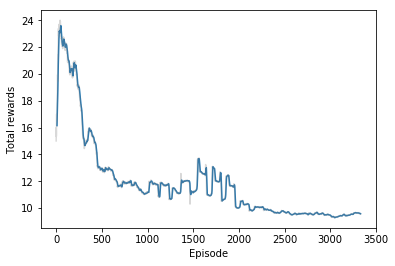

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

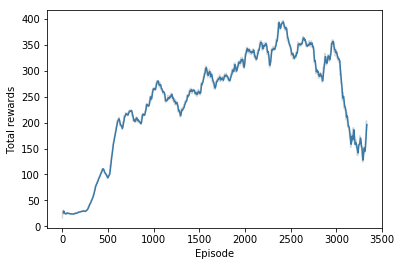

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

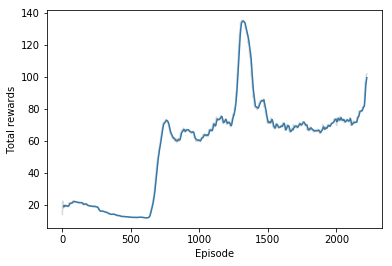

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

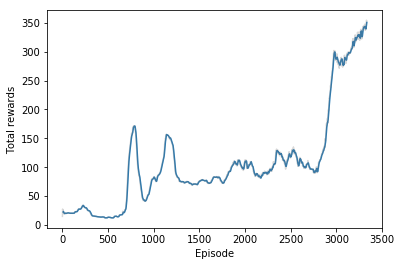

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

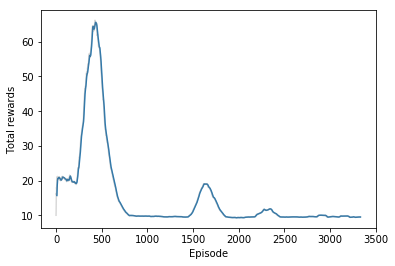

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

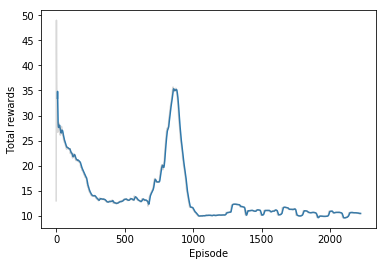

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

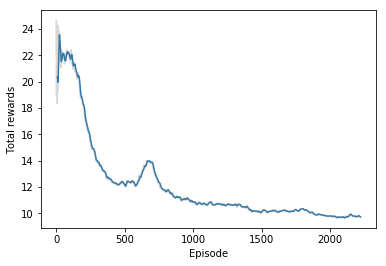

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

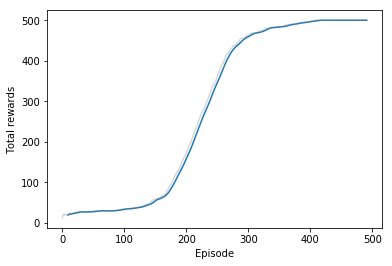

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

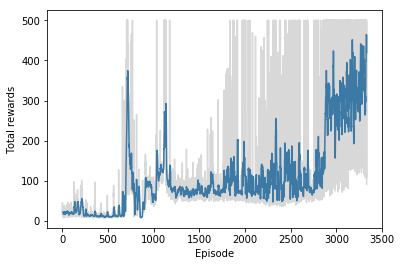

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

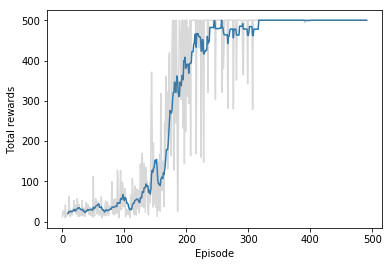

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.